In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random
import os
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix,f1_score, classification_report
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from keras.callbacks import EarlyStopping
from sklearn.svm import OneClassSVM
from sklearn.model_selection import GridSearchCV

In [2]:
SEED=42

In [3]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
seed_everything(SEED) 

# EDA


In [4]:
df = pd.read_csv('./creditcard.csv') #data
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


Data는 원래의 데이터를 PCA를 사용해 28차원으로 축소한 28개의 특성과 시간, 거래금액, Label이 존재하는 데이터

In [5]:
df['Class'].value_counts()

0    284315
1       492
Name: Class, dtype: int64

Data는 심각한 불균형을 이루고 있는 것을 확인 가능

In [6]:
df.drop(['Time','Amount'],axis=1,inplace=True)
print(df)

               V1         V2        V3        V4        V5        V6  \
0       -1.359807  -0.072781  2.536347  1.378155 -0.338321  0.462388   
1        1.191857   0.266151  0.166480  0.448154  0.060018 -0.082361   
2       -1.358354  -1.340163  1.773209  0.379780 -0.503198  1.800499   
3       -0.966272  -0.185226  1.792993 -0.863291 -0.010309  1.247203   
4       -1.158233   0.877737  1.548718  0.403034 -0.407193  0.095921   
...           ...        ...       ...       ...       ...       ...   
284802 -11.881118  10.071785 -9.834783 -2.066656 -5.364473 -2.606837   
284803  -0.732789  -0.055080  2.035030 -0.738589  0.868229  1.058415   
284804   1.919565  -0.301254 -3.249640 -0.557828  2.630515  3.031260   
284805  -0.240440   0.530483  0.702510  0.689799 -0.377961  0.623708   
284806  -0.533413  -0.189733  0.703337 -0.506271 -0.012546 -0.649617   

              V7        V8        V9       V10  ...       V20       V21  \
0       0.239599  0.098698  0.363787  0.090794  ...  0.25141

이 주제에서는 원본 데이터에 차원축소가 진행된 28개의 특성인 V1~V28만 사용할 예정

In [7]:
df.shape 

(284807, 29)

In [8]:
df.isnull().sum() #결측치 존재하지 않음

V1       0
V2       0
V3       0
V4       0
V5       0
V6       0
V7       0
V8       0
V9       0
V10      0
V11      0
V12      0
V13      0
V14      0
V15      0
V16      0
V17      0
V18      0
V19      0
V20      0
V21      0
V22      0
V23      0
V24      0
V25      0
V26      0
V27      0
V28      0
Class    0
dtype: int64

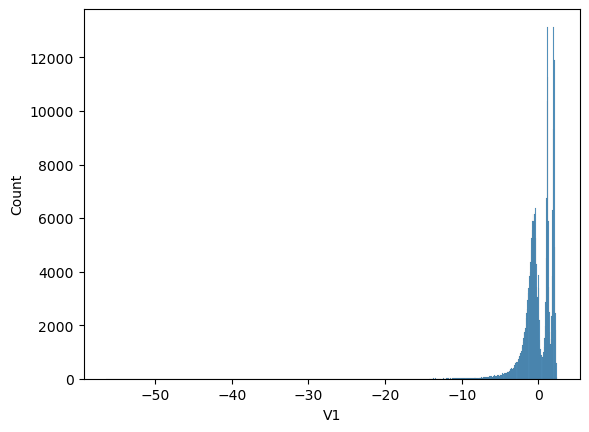

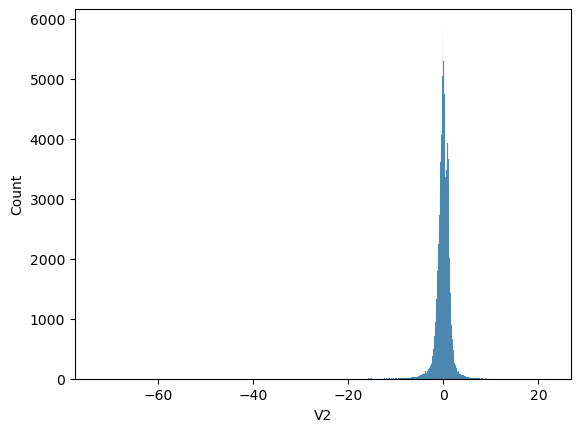

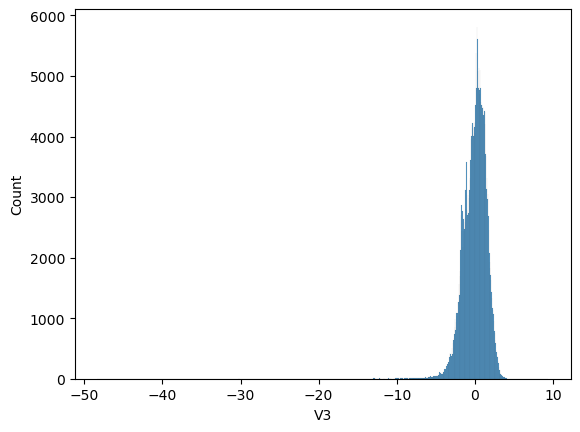

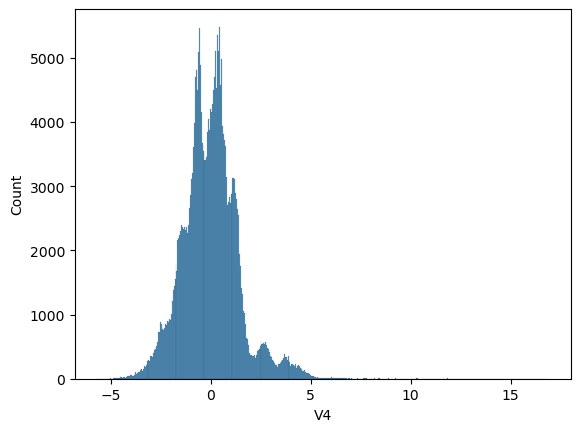

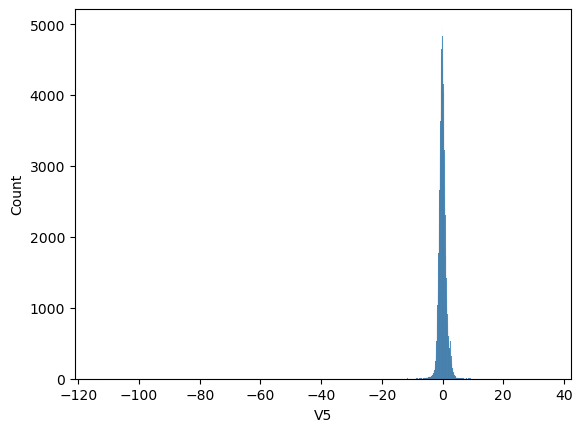

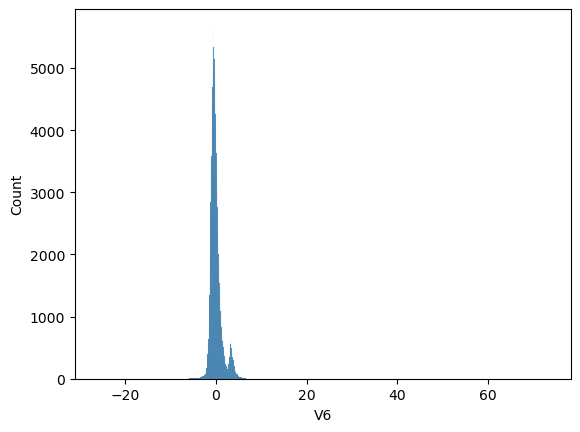

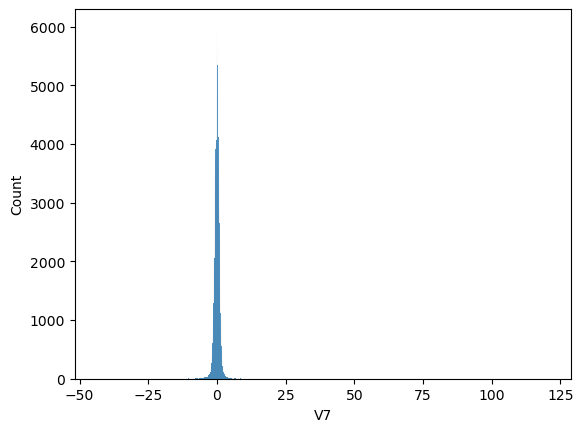

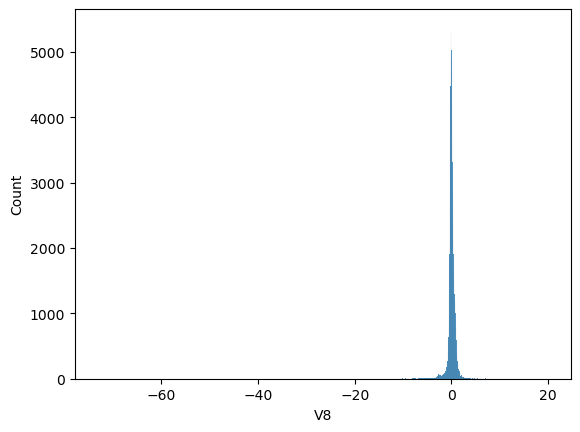

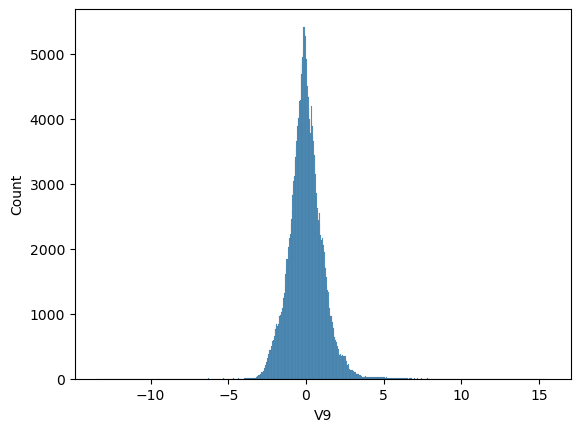

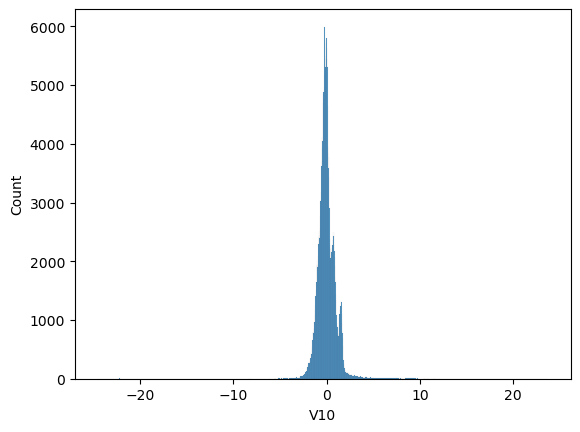

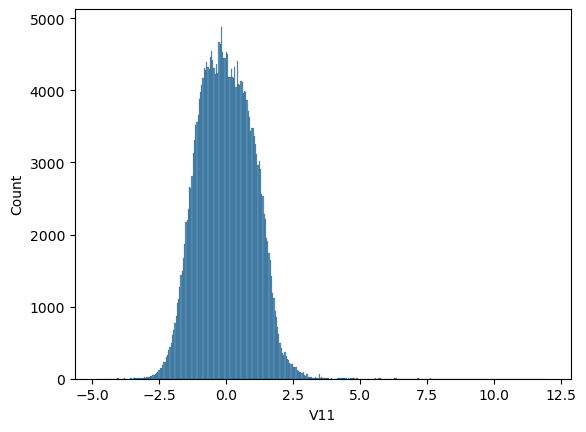

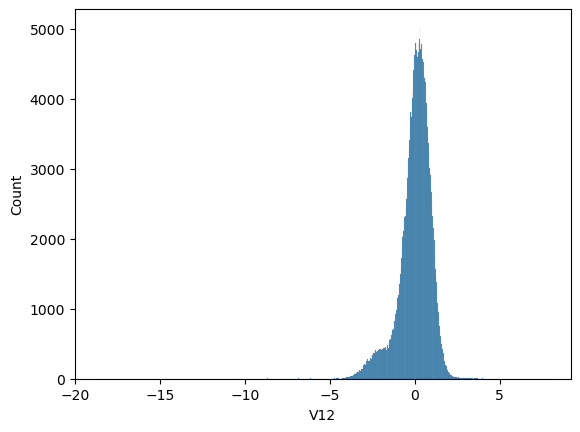

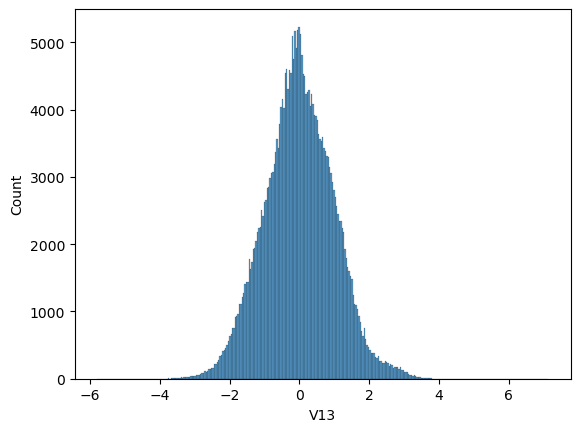

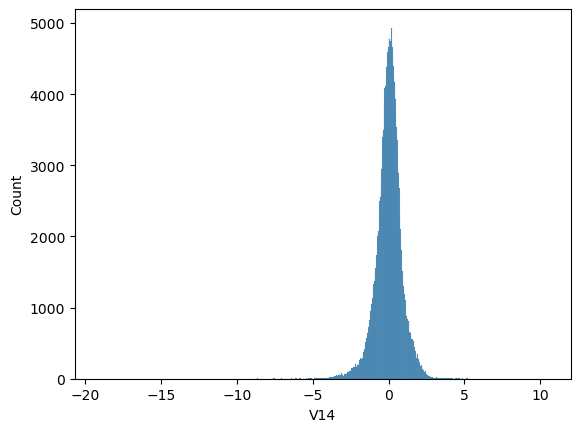

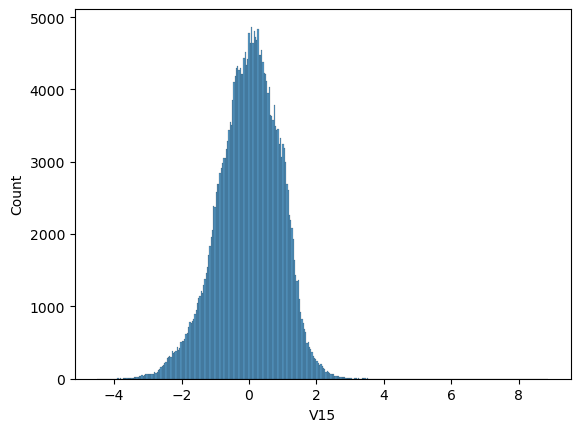

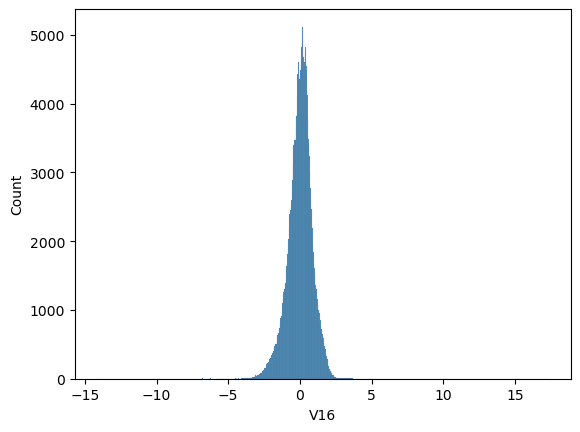

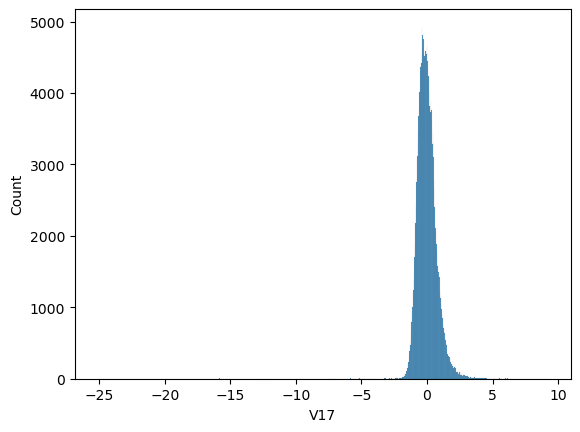

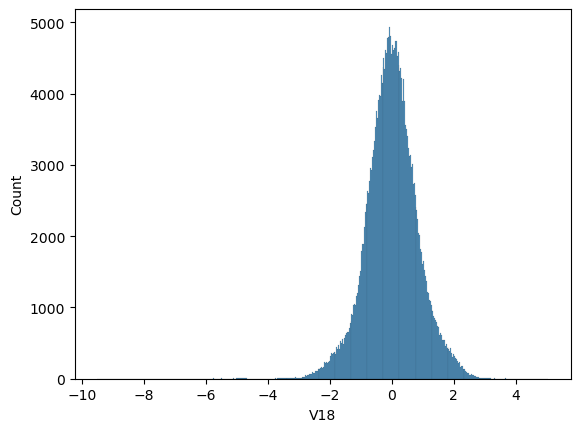

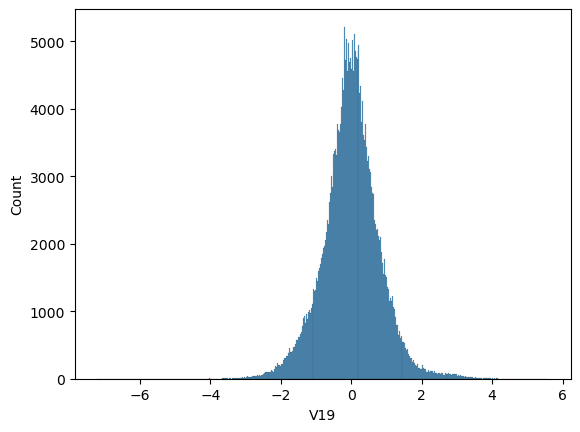

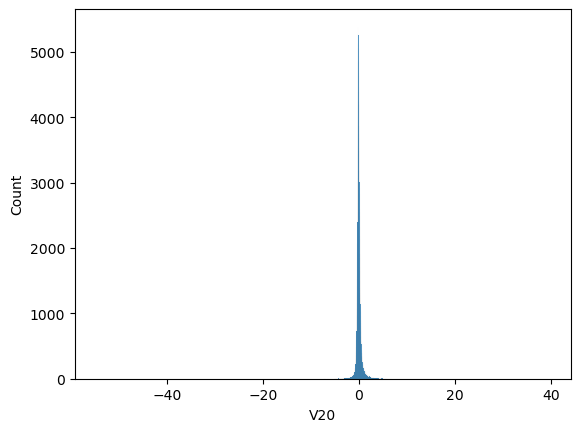

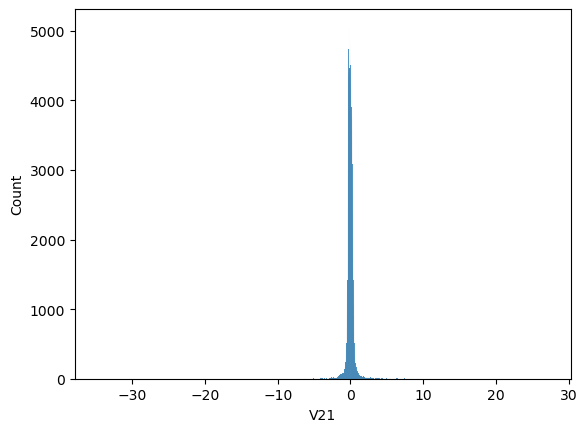

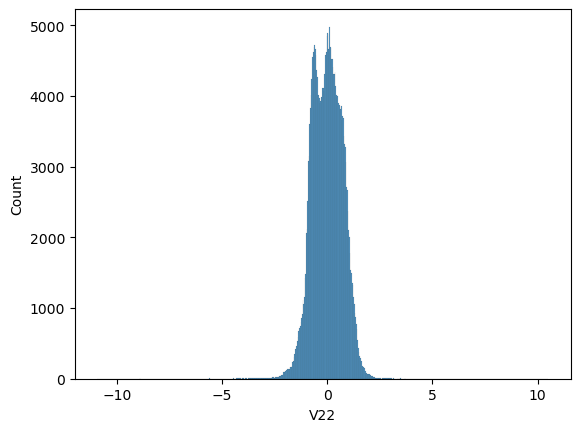

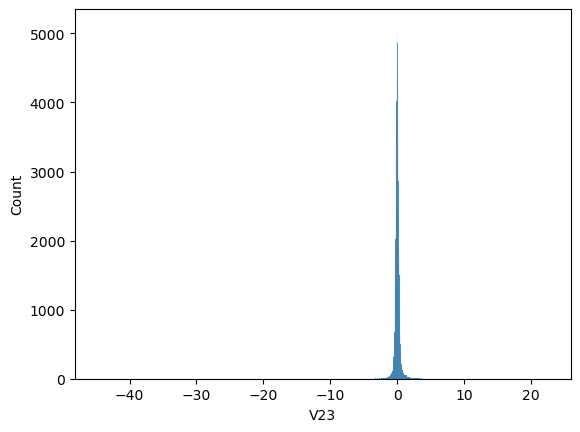

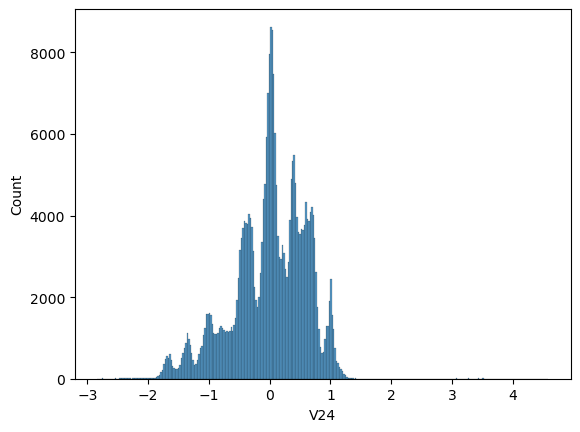

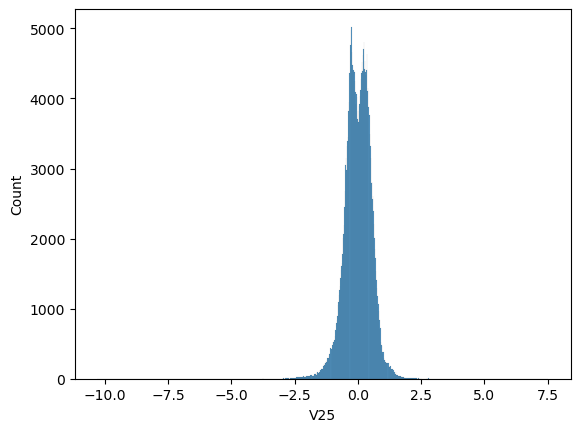

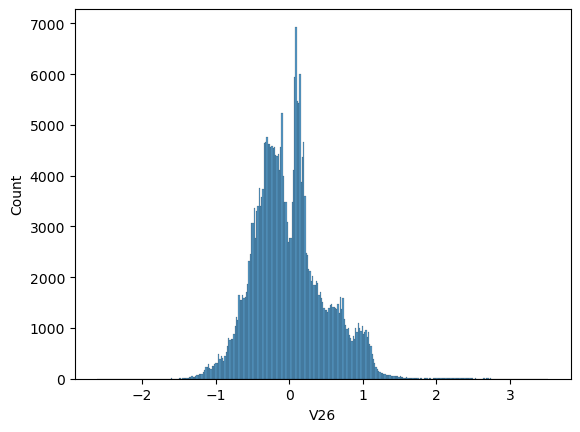

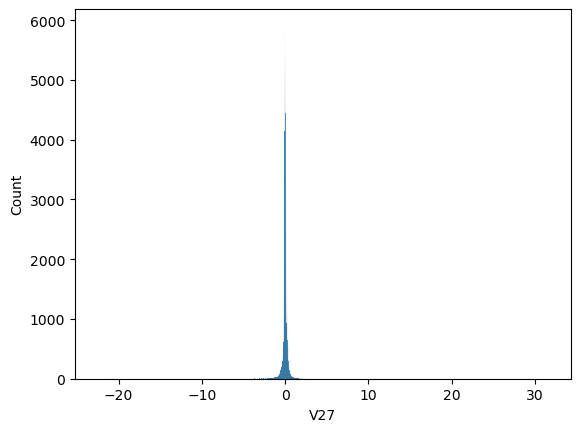

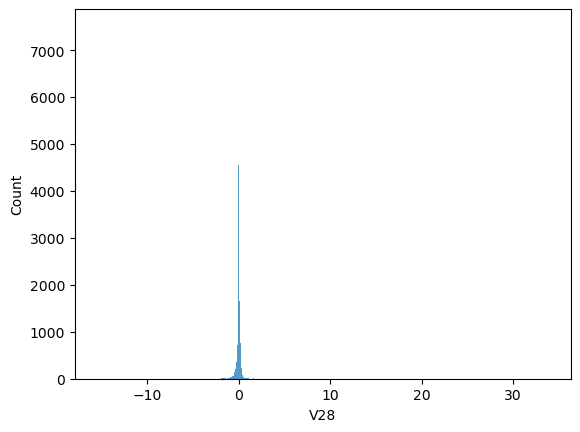

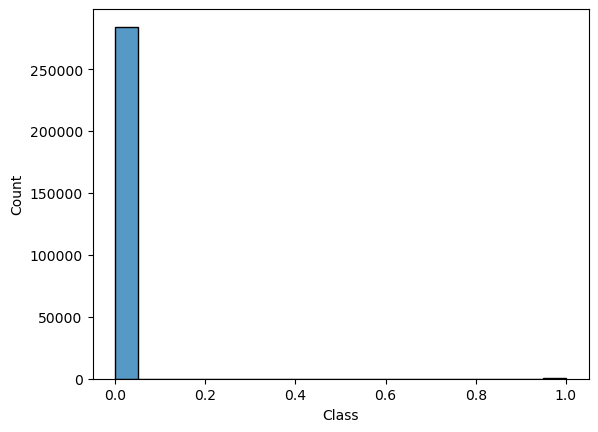

In [9]:
col = df.columns # 특성별 데이터 값의 분포. 대부분 정규분포를 띔
for e in col:
    sns.histplot(x=df[e])
    plt.show()

In [10]:
correlation_df =df.corr(method='pearson') #상관계수 Dataframe 생성

In [11]:
correlation_df.loc[abs(correlation_df['Class']) > 0.1 , ['Class']] 
#'Class' Column과 상관계수가 0.1 이상인 특성을 선택

,Class
V1,-0.101347
V3,-0.192961
V4,0.133447
V7,-0.187257
V10,-0.216883
V11,0.154876
V12,-0.260593
V14,-0.302544
V16,-0.196539
V17,-0.326481


<AxesSubplot: >

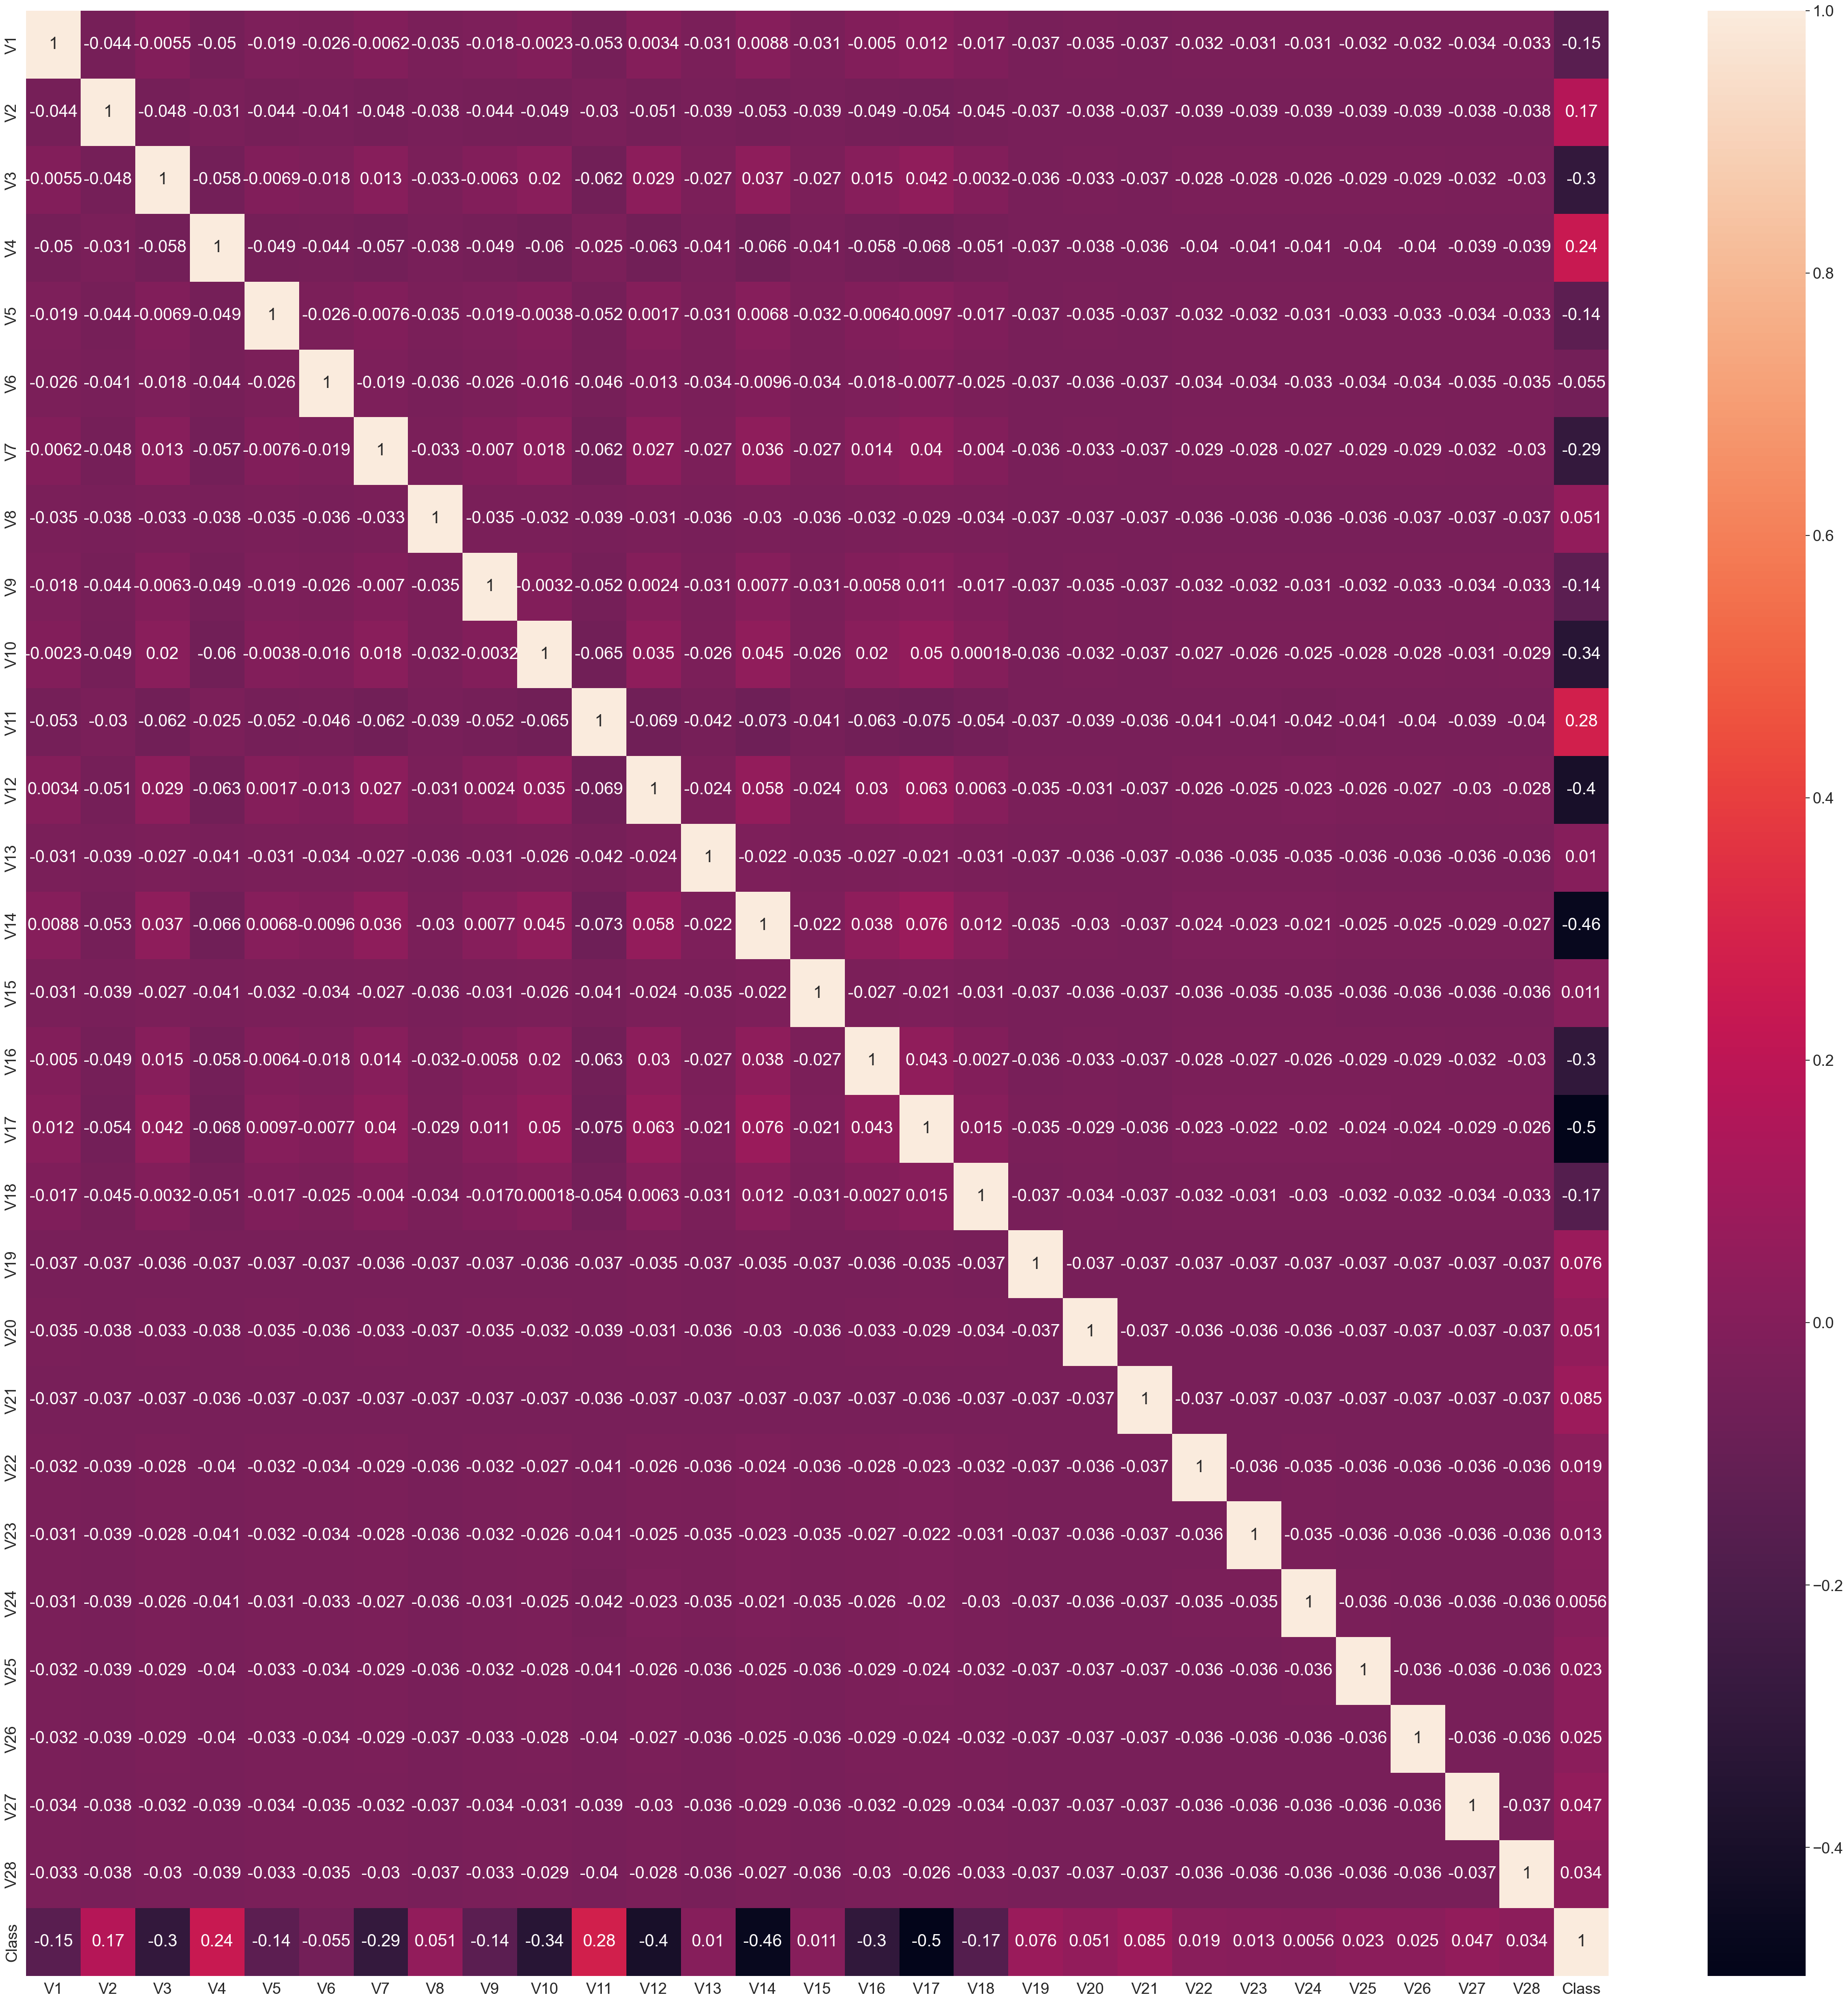

In [12]:
plt.figure(figsize=(50,50))
sns.set(font_scale=2.0) 
sns.heatmap(correlation_df.astype(float).corr(),annot = True)

In [13]:
df = df[['V1','V3','V4','V7','V10','V11','V12','V14','V16','V17','V18','Class']]

In [14]:
df

,V1,V3,V4,V7,V10,V11,V12,V14,V16,V17,V18,Class
0,-1.359807,2.536347,1.378155,0.239599,0.090794,-0.551600,-0.617801,-0.311169,-0.470401,0.207971,0.025791,0
1,1.191857,0.166480,0.448154,-0.078803,-0.166974,1.612727,1.065235,-0.143772,0.463917,-0.114805,-0.183361,0
2,-1.358354,1.773209,0.379780,0.791461,0.207643,0.624501,0.066084,-0.165946,-2.890083,1.109969,-0.121359,0
3,-0.966272,1.792993,-0.863291,0.237609,-0.054952,-0.226487,0.178228,-0.287924,-1.059647,-0.684093,1.965775,0
4,-1.158233,1.548718,0.403034,0.592941,0.753074,-0.822843,0.538196,-1.119670,-0.451449,-0.237033,-0.038195,0
...,...,...,...,...,...,...,...,...,...,...,...,...
284802,-11.881118,-9.834783,-2.066656,-4.918215,4.356170,-1.593105,2.711941,4.626942,1.107641,1.991691,0.510632,0
284803,-0.732789,2.035030,-0.738589,0.024330,-0.975926,-0.150189,0.915802,-0.675143,-0.711757,-0.025693,-1.221179,0
284804,1.919565,-3.249640,-0.557828,-0.296827,-0.484782,0.411614,0.063119,-0.510602,0.140716,0.313502,0.395652,0
284805,-0.240440,0.702510,0.689799,-0.686180,-0.399126,-1.933849,-0.962886,0.449624,-0.608577,0.509928,1.113981,0


In [15]:
df.sort_values('Class')

,V1,V3,V4,V7,V10,V11,V12,V14,V16,V17,V18,Class
0,-1.359807,2.536347,1.378155,0.239599,0.090794,-0.551600,-0.617801,-0.311169,-0.470401,0.207971,0.025791,0
189814,-5.809290,-2.698260,4.886691,-1.417844,1.143182,-0.705144,-0.074544,2.219106,0.397685,0.580084,0.844710,0
189815,2.136948,-2.440339,-0.280203,0.607870,0.201116,0.482470,0.423504,1.079802,-0.239694,-0.686932,0.226090,0
189816,-1.156768,3.113868,4.420894,-1.234156,1.465244,0.530256,-0.340789,-0.001109,0.874548,-0.432920,1.550215,0
189817,1.767787,-2.215079,0.511939,0.509947,-0.615062,-0.809022,0.097478,-0.926483,0.381075,0.255910,0.659978,0
...,...,...,...,...,...,...,...,...,...,...,...,...
42741,-9.001351,-12.423635,7.519929,-9.984287,-13.215172,6.895181,-13.279700,-13.417012,-10.922655,-21.906493,-8.829820,1
107067,-1.512516,-1.601052,2.813401,-1.520895,-4.056293,1.553756,-2.743551,-5.428788,-3.727188,-3.946300,-1.680286,1
10897,-15.398845,-19.026912,11.165526,-14.913330,-14.166795,10.277769,-14.985434,-14.666389,-8.333242,-12.602596,-4.876683,1
191690,1.183931,-6.161997,5.543972,-1.005508,-3.851722,4.513355,-4.858312,-10.006243,0.574875,0.188470,1.649224,1


# Preprocessing

In [16]:
train = df.sort_values('Class')
train.reset_index(inplace=True,drop=True)

In [17]:
x = train.drop('Class',axis=1)
y = train['Class']

In [18]:
train_x = x[:][:200000]
train_y = y[:200000]
x=x[:][200000:]
y=y[:][200000:]
val_x, test_x, val_y, test_y = train_test_split(x, y, test_size=0.5, random_state=SEED,stratify=y)
print(train_x.shape)
print(val_x.shape)
print(test_x.shape)
print(train_y.value_counts())
print(val_y.value_counts())
print(test_y.value_counts())


(200000, 11)
(42403, 11)
(42404, 11)
0    200000
Name: Class, dtype: int64
0    42157
1      246
Name: Class, dtype: int64
0    42158
1      246
Name: Class, dtype: int64


train : val : test = 8 : 1 : 1로 데이터 분리. 

In [19]:
val_normal,val_anomaly  = val_y.value_counts()
val_anomaly_ratio = val_anomaly / (val_normal+val_anomaly)

In [20]:
val_anomaly_ratio #전체데이터 중 anomaly ratio
#nu 파라미터를 조정하기 위해서 validation anomaly data ratio를 찾아줌

0.0058014763106383985

In [21]:
scaler = MinMaxScaler()
train_x_minmax = scaler.fit_transform(train_x)
val_x_minmax = scaler.transform(val_x)
#특성들의 scale을 맞추어 주기 위해 정규화 진행

In [22]:
print(train_x_minmax.shape)
print(val_x_minmax.shape)

(200000, 11)
(42403, 11)


## Training

In [23]:
best_f1 = 0
best_nu = 0
for i in range(101):
    nu = val_anomaly_ratio+ 0.0001*(i-50) 
    #validation anomaly ratio - 5e-3 부터 validation anomaly ratio +5e-3 까지 파라미터 찾기
    
    one_class_svm = OneClassSVM(nu=nu, kernel = 'rbf', gamma = "auto").fit(train_x_minmax)
    pred_val = one_class_svm.predict(val_x_minmax)
    pred_val = [1 if i==-1 else 0 for i in pred_val]
    print("NU : "+ str(nu))
    print(np.unique(pred_val, return_counts=True))
    print(confusion_matrix(val_y,pred_val))
    f1 = f1_score(val_y, pred_val,average='macro')
    print(f1)
    print("------------------------")
    if best_f1 < f1:
        best_f1 = f1
        best_nu = nu
#최고 val_f1, best_nu 저장

NU : 0.0008014763106383984
(array([0, 1]), array([42277,   126]))
[[42136    21]
 [  141   105]]
0.781298735335941
------------------------
NU : 0.0009014763106383987
(array([0, 1]), array([42253,   150]))
[[42122    35]
 [  131   115]]
0.7894207445860093
------------------------
NU : 0.001001476310638398
(array([0, 1]), array([42240,   163]))
[[42120    37]
 [  120   126]]
0.8071383318095555
------------------------
NU : 0.0011014763106383984
(array([0, 1]), array([42228,   175]))
[[42118    39]
 [  110   136]]
0.822157521719604
------------------------
NU : 0.0012014763106383986
(array([0, 1]), array([42225,   178]))
[[42117    40]
 [  108   138]]
0.8245947338317259
------------------------
NU : 0.001301476310638398
(array([0, 1]), array([42220,   183]))
[[42114    43]
 [  106   140]]
0.8254573843063597
------------------------
NU : 0.0014014763106383983
(array([0, 1]), array([42211,   192]))
[[42109    48]
 [  102   144]]
0.8278781606478077
------------------------
NU : 0.0015014763

NU : 0.006701476310638398
(array([0, 1]), array([41977,   426]))
[[41933   224]
 [   44   202]]
0.7990025407315089
------------------------
NU : 0.0068014763106383986
(array([0, 1]), array([41975,   428]))
[[41931   226]
 [   44   202]]
0.7980986427855845
------------------------
NU : 0.006901476310638399
(array([0, 1]), array([41970,   433]))
[[41926   231]
 [   44   202]]
0.7958618844609944
------------------------
NU : 0.007001476310638398
(array([0, 1]), array([41968,   435]))
[[41924   233]
 [   44   202]]
0.7949762542192781
------------------------
NU : 0.0071014763106383985
(array([0, 1]), array([41966,   437]))
[[41922   235]
 [   44   202]]
0.7940957402732237
------------------------
NU : 0.007201476310638399
(array([0, 1]), array([41964,   439]))
[[41920   237]
 [   44   202]]
0.793220297803555
------------------------
NU : 0.007301476310638398
(array([0, 1]), array([41959,   444]))
[[41915   242]
 [   44   202]]
0.7910535899010407
------------------------
NU : 0.007401476310

In [24]:
print(train_x_minmax.shape)
print(val_x_minmax.shape)

(200000, 11)
(42403, 11)


In [25]:
print("best nu : " + str(best_nu))
print("best val f1 : " + str(best_f1))

best nu : 0.0025014763106383986
best val f1 : 0.8529444619874822


In [26]:
test_x_minmax = scaler.transform(test_x)

In [27]:
one_class_svm_best = OneClassSVM(nu=best_nu, kernel = 'rbf', gamma = "auto").fit(train_x_minmax)

In [28]:
pred_test = one_class_svm_best.predict(test_x_minmax)
pred_test = [1 if i==-1 else 0 for i in pred_test]
print(np.unique(pred_test, return_counts=True))
print(confusion_matrix(test_y,pred_test))
print(f1_score(test_y, pred_test,average='macro'))
print(classification_report(test_y, pred_test))
#Best model로 결과 뽑음

(array([0, 1]), array([42128,   276]))
[[42056   102]
 [   72   174]]
0.8323011334424855
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     42158
           1       0.63      0.71      0.67       246

    accuracy                           1.00     42404
   macro avg       0.81      0.85      0.83     42404
weighted avg       1.00      1.00      1.00     42404



In [31]:
scaler = StandardScaler()
train_x_normal = scaler.fit_transform(train_x)
val_x_normal = scaler.transform(val_x)
#Standard scaler 적용해서 다시 실험

In [32]:
best_f1 = 0
best_nu = 0
for i in range(101):
    nu = val_anomaly_ratio+ 0.0001*(i-50)
    one_class_svm = OneClassSVM(nu=nu, kernel = 'rbf', gamma = "auto").fit(train_x_normal)
    pred_val = one_class_svm.predict(val_x_normal)
    pred_val = [1 if i==-1 else 0 for i in pred_val]
    print("NU : "+ str(nu))
    print(np.unique(pred_val, return_counts=True))
    print(confusion_matrix(val_y,pred_val))
    f1 = f1_score(val_y, pred_val,average='macro')
    print(f1)
    print("------------------------")
    if best_f1 < f1:
        best_f1 = f1
        best_nu = nu
#최고 val_f1, best_nu 저장

NU : 0.0008014763106383984
(array([0, 1]), array([41985,   418]))
[[41936   221]
 [   49   197]]
0.7950823163825467
------------------------
NU : 0.0009014763106383987
(array([0, 1]), array([41985,   418]))
[[41936   221]
 [   49   197]]
0.7950823163825467
------------------------
NU : 0.001001476310638398
(array([0, 1]), array([41982,   421]))
[[41933   224]
 [   49   197]]
0.7937300083838921
------------------------
NU : 0.0011014763106383984
(array([0, 1]), array([42003,   400]))
[[41954   203]
 [   49   197]]
0.8034564120825436
------------------------
NU : 0.0012014763106383986
(array([0, 1]), array([42003,   400]))
[[41954   203]
 [   49   197]]
0.8034564120825436
------------------------
NU : 0.001301476310638398
(array([0, 1]), array([42003,   400]))
[[41954   203]
 [   49   197]]
0.8034564120825436
------------------------
NU : 0.0014014763106383983
(array([0, 1]), array([42003,   400]))
[[41954   203]
 [   49   197]]
0.8034564120825436
------------------------
NU : 0.00150147

NU : 0.006701476310638398
(array([0, 1]), array([41909,   494]))
[[41867   290]
 [   42   204]]
0.7737010367015363
------------------------
NU : 0.0068014763106383986
(array([0, 1]), array([41924,   479]))
[[41883   274]
 [   41   205]]
0.7808854269835861
------------------------
NU : 0.006901476310638399
(array([0, 1]), array([41905,   498]))
[[41864   293]
 [   41   205]]
0.7735510054918502
------------------------
NU : 0.007001476310638398
(array([0, 1]), array([41904,   499]))
[[41863   294]
 [   41   205]]
0.7731751846234386
------------------------
NU : 0.0071014763106383985
(array([0, 1]), array([41901,   502]))
[[41860   297]
 [   41   205]]
0.7720536545748969
------------------------
NU : 0.007201476310638399
(array([0, 1]), array([41919,   484]))
[[41878   279]
 [   41   205]]
0.7789188777016489
------------------------
NU : 0.007301476310638398
(array([0, 1]), array([41901,   502]))
[[41860   297]
 [   41   205]]
0.7720536545748969
------------------------
NU : 0.00740147631

In [33]:
print("best nu : " + str(best_nu))
print("best val f1 : " + str(best_f1))

best nu : 0.0023014763106383985
best val f1 : 0.8035816028274838


In [34]:
test_x_normal = scaler.transform(test_x)

In [35]:
one_class_svm_best = OneClassSVM(nu=best_nu, kernel = 'rbf', gamma = "auto").fit(train_x_normal)

In [36]:
pred_test = one_class_svm_best.predict(test_x_normal)
pred_test = [1 if i==-1 else 0 for i in pred_test]
print(np.unique(pred_test, return_counts=True))
print(confusion_matrix(test_y,pred_test))
print(f1_score(test_y, pred_test,average='macro'))
print(classification_report(test_y, pred_test))
#Best model로 결과 뽑음

(array([0, 1]), array([41971,   433]))
[[41925   233]
 [   46   200]]
0.792892642201013
              precision    recall  f1-score   support

           0       1.00      0.99      1.00     42158
           1       0.46      0.81      0.59       246

    accuracy                           0.99     42404
   macro avg       0.73      0.90      0.79     42404
weighted avg       1.00      0.99      0.99     42404

